### Observations of Snow from space - Snow monthly product

In [2]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [3]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

##### User input:


In [4]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
# lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
lat, lon, buffer_m, buffer_n = -36.48, 148.26, 5200, 5200 #nsw
time_range = ('2010-01-01', '2019-12-31')

resolution = (-25, 25)

landsat_goodquality_prop = 0.3


ndsi_threshold = 0.2
ndvi_threshold = 0.3
#ndwi_threshold = 0.15
red_threshold = 1000

elev = 1800
elev1 = 1500

In [5]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}


In [6]:
DEAPlotting.display_map(y=query['y'], x=query['x'])

#### Loading data
Both ACCA and fmask cloudmasking products at times classify snow pixels as cloud - depending on the region/time range being investigated, the user may wish to adjust the snow cloudmask in the cell below. 

In [6]:
# snow_cloudmask can be altered to use either ACCA, fmask or both
snow_cloudmask = dict(    #cloud_acca='no_cloud',
                     cloud_fmask='no_cloud',
                     #cloud_shadow_acca='no_cloud_shadow',
                     cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds10s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_cloudmask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Loading 149 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 23 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [10]:
# loading a true color image
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, product = 'nbar', query=query, sensors=['ls8', 'ls7','ls5'], 
        bands_of_interest=['red', 'green', 'blue'], masked_prop=landsat_goodquality_prop, mask_pixel_quality=False, ls7_slc_off=False)

Loading ls8
    Loading 144 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 21 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [16]:

valid_ds10s = np.isfinite(landsat_ds10s.swir1)

In [12]:
ndsi_ds10s = (landsat_ds10s.green - landsat_ds10s.swir1) / (landsat_ds10s.green + landsat_ds10s.swir1)
ndvi_ds10s = (landsat_ds10s.nir - landsat_ds10s.red) / (landsat_ds10s.nir + landsat_ds10s.red)

In [13]:
snow_ds_n = ndsi_ds10s > ndsi_threshold
noveg_ds10s = ndvi_ds10s < ndvi_threshold
red_ds10s = landsat_ds10s.red > 1000
snow_ds10s = noveg_ds10s & snow_ds_n & red_ds10s

Plot of snow/no-snow for given region - along side a true colour image. NDSI/NDVI threshold values can be adjusted in the user input nea the top of the notebook.

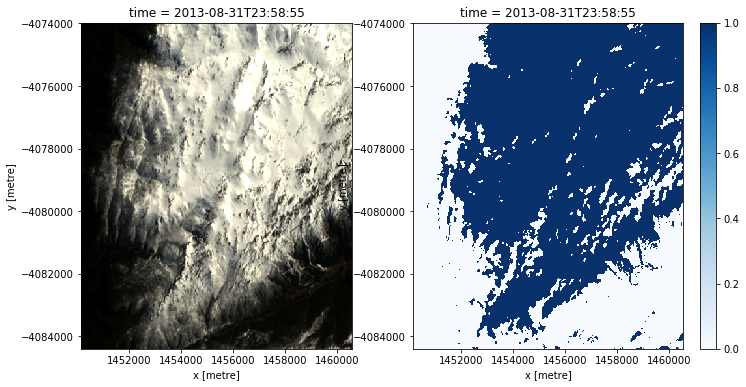

In [14]:
fig, axes = plt.subplots(ncols=2, figsize = (12, 6), gridspec_kw={'width_ratios': [4, 5]})
landsat_ds[['red', 'green', 'blue']].isel(time=28).to_array().plot.imshow(robust=True, ax=axes[0])
snow_ds10s.isel(time=31).plot(cmap='Blues', ax=axes[1])


#### Annual monthly product

In [17]:
# annual product for 2015
snow_2015 = snow_ds10s.sel(time=slice('2015-01-01', '2015-12-31'))
valid_2015 = valid_ds10s.sel(time=slice('2015-01-01', '2015-12-31'))

In [18]:
valid_sum_2015 = valid_2015.groupby('time.month').sum(dim='time')
snow_sum_2015 = snow_2015.groupby('time.month').sum(dim='time')

In [19]:
snow_sum_2015.isel(month=8)

<xarray.DataArray (y: 417, x: 416)>
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
  * y        (y) float64 -4.074e+06 -4.074e+06 ... -4.084e+06 -4.084e+06
  * x        (x) float64 1.45e+06 1.45e+06 1.45e+06 ... 1.461e+06 1.461e+06
    month    int64 9

In [20]:
snow_month=snow_sum_2015.where(snow_sum_2015<1, 1)
valid_month=valid_sum_2015.where(valid_sum_2015<1,1)

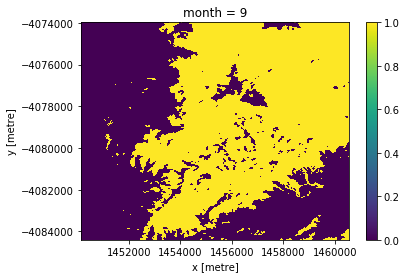

In [21]:
snow_month.isel(month=8).plot()

In [22]:
snow_month_sum=snow_month.sum(dim=['month'])
valid_month_sum=valid_month.sum(dim=['month'])

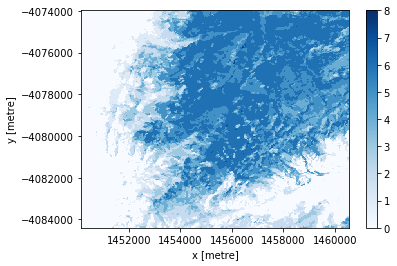

In [23]:
# annual monthly plot for 2015
snow_month_sum.plot(cmap='Blues')

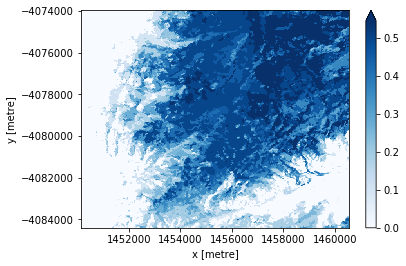

In [24]:

snow_prop_month1 = snow_month_sum/valid_month_sum
snow_prop_month1.plot(cmap='Blues', robust=True)

In [25]:
snow_2010 = snow_ds10s.sel(time=slice('2010-01-01', '2010-12-31'))
snow_2011 = snow_ds10s.sel(time=slice('2011-01-01', '2011-12-31'))
snow_2012 = snow_ds10s.sel(time=slice('2012-01-01', '2012-12-31'))
snow_2013 = snow_ds10s.sel(time=slice('2013-01-01', '2013-12-31'))
snow_2014 = snow_ds10s.sel(time=slice('2014-01-01', '2014-12-31'))
snow_2015 = snow_ds10s.sel(time=slice('2015-01-01', '2015-12-31'))
snow_2016 = snow_ds10s.sel(time=slice('2016-01-01', '2016-12-31'))
snow_2017 = snow_ds10s.sel(time=slice('2017-01-01', '2017-12-31'))
snow_2018 = snow_ds10s.sel(time=slice('2018-01-01', '2018-12-31'))
snow_2019 = snow_ds10s.sel(time=slice('2019-01-01', '2019-12-31'))

In [26]:
snow_sum2010 = snow_2010.groupby('time.month').sum(dim='time')
snow_month2010=snow_sum2010.where(snow_sum2010<1, 1)
snow_sum_pp2010=snow_month2010.sum(dim=['month'])
d=snow_sum_pp2010

In [27]:
snow_2010s = [snow_2011, snow_2013, snow_2015, snow_2016, snow_2017, snow_2018, snow_2019]

for i in snow_2010s:
    a = i.groupby('time.month').sum(dim='time')
    b=a.where(a<1, 1)
    c=b.sum(dim=['month'])
    d=d+c

d=d.where(d > 0)

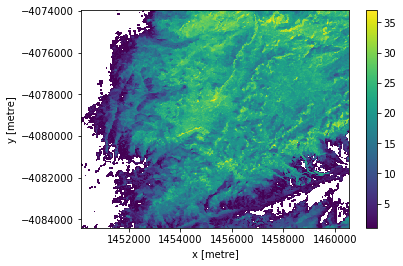

In [28]:
# decadal plot (2010s)
d.plot()